In [24]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from auxiliary.auxiliary import simulate_data

In [25]:
np.random.seed(123)

# Stacking/ Jackknife Model Averaging and its Use in Regression Discontinuity Design
---

## Introduction
---

A common occurrence in data-driven Economics is that the researcher faces uncertainty about several facets of a statistical model as well as the results from its calibration. While the uncertainty in the parameter estimates of a model is typically reported by showing at least the standard deviation of the parameter estimates, it is not common practice in Economics to discuss the implications of uncertainty about the specific form of the statistical model. It is rather common to select one model among several competing models (maybe using some model selection techniques) from that on pretending that it is the true one while performing some robustness checks using other model specifications (Moral-Benito (2015)). Fletcher (2019) argues that the typical problem with this negligence of remaining model uncertainty is that parameter estimates might be biased and uncertainty is underestimated. This approach yields confidence intervals of the estimated parameters that are too optimistic in the sense that the true coverage probability is below its nominal level when not accounting for this uncertainty. This might cause the resulting inference to be seriously flawed. This aspect is a major reason why model averaging might be useful in Economics. Model averaging takes information from all competing models into account and therefore explicitly includes model uncertainty into its parameter estimates as well as its confidence intervals. Steel (2019) summarizes the tradeoff between model selection and averaging by the question what the researcher is interested in and what the previous certainty of knowledge is. If one is interested in the true model and is certain that one of the competing models must be the true one, then model selection yields the best results as it can select the true one without confounding it with the others. Although even that advantage is questionable as Zhang (2015) proves that several model avergaing estimators (among them Jackknife Model Averaging) are actually root-n consistent if the true model is among the ones that is averaged over. Further when there is considerable uncertainty about the model form, then an ensemble of those constructed by averaging yields more reliable results as it takes information from all of them into account.

In Economics, the application of model averaging is imaginable in many situations. For example, in a more structural framework, often there are competing theories that inform the statistical model such as human capital as opposed to signaling theory. Another situation commonly encountered is the question which covariates should be included in a linear regression model (compare Steel (2019)). The last situation is often encountered in Regression Discontinuity Design (RDD). There is usually uncertainty about the polynomial with which the assignment variable affects the outcome variable. In the highly cited prationers' guide to RDD by Lee and Lemieux (2010) they argue that typically there is no theory available on which to base the decision for the choice of polynomial. This leads them to the suggestion to use model selection based on the Akaike information criterion (AIC) as a standard way to choose the polynomial. As there is no strong prior which polynomial to add and whether any of them is actually a good representation of the true model, for the above reasons, model averaging should be a suitable alternative to the suggested model selection procedure. It might be even superior in many situations as the actual coverage probability might be closer to its nominal one. In my first simualtion, I therefore take a typical applied RDD paper (Bronzini and Iachini (2014)) that follows quite closely the suggestions in Lee and Lemieux (2010) to benchmark whether model averaging might actually perform better than selection based on the AIC (in the sense of bias, and root mean squared error in the treatment effect as well as the coverage probability of the 95% confidence intervals). Unfortunately, I noticed only after already having set up my first simulation that there is already a published paper that has a similar idea in mind (Button (2016)). In the light of that, I adapted my first simulation study to incorporate some of the author's good ideas. For the model averaging I focus on the approach of stacking (Wolpert (1992)) which has been rediscovered in the Econometrics literature as Jackknife Model Averaging (JMA) based on Hansen and Racine (2012). My setup is also an improvement over Button's in the sense that I allow for heteroskedasticity which generally works in favor of model averaging using JMA as opposed to model selection using the AIC (I will discuss this further later). In general, my simulation differs in a few dimensions which I will elaborate on later. 

In a second simulation study, I go beyond the general ideas also found in Button (2016). As JMA is based on a leave one out cross validation procedure that aims at minimizing a cross validation criterion approximating the expected test mean squared error depending on the weights given to the competing models for averaging, I explore whether JMA can also be used for bandwidth selection in RDD in a self-sufficient way. As in RDD one is mainly interested in the comparison of individuals around a certain cutoff, it remains to determine which individuals to include around the cutoff to determine the treatment effect. Lee and Lemieux (2010) suggest the procedure in Imbens and Lemieux (2008) involving the use of local linear regressions around the cutoff for several bandwidths, calculating a cross validation criterion for each and then choosing the bandwidth that minimizes it. The approach in JMA is similar while accounting for different possible specifications such as polynomial ones. Hence, JMA might be an alternative for bandwidth selection (especially when local linearity is a poor approximation) which I explore in the second simulation of my project. 

The general structure of my project paper is the following. In the next section I introduce stacking in general and the specific implementation of it called Jackknife Model Averaging based on Hansen and Racine (2012) which involves a convenient calculation for linear regression models as needed in RDD. In section three, I introduce the general idea of Regression Discontinuity Design and explain the ideas behind Bronzini and Iachini (2014) on which my first data generating process is based. In section four I run my first simulation study in which I check the usefulness of JMA for determination of the treatment in the verge of uncertainty about the polynomial order of the assignment variable. In section five, I pick up the first simulation to see how JMA behaves as a tool for bandwidth selection and then introduce a slightly different data generating process to further pronounce its potential strength. In the last section I shortly conclude with a summary of my findings.

## Stacking/ Jackknife Model Averaging
---

As already emphasized in the introduction, model averaging has its appeal in situations where the exact form of the model is unknown. It has an advantage over model selection in the sense that it incorporates the resulting uncertainty explicitly in the modeling by combining competing models and extracting information of each of them. This makes it possible to account for the model uncertainty in the uncertainty around the estimated model parameters making inference more stable in comparison to model selection (Fletcher (2019)). Generally, there are two main strands of model averaging present. The first follows the Bayesian paradigm and is consequently called Bayesian Model Averaging. It is characterized by the fact that priors on the true parameters and the models must be formed. The outcome is a weighted average of the posteriors from different models with the weight being based on the posterior probability that a model is true. The main objective of it is to rather identify the true model as opposed to improving prediction quality. While this is generally a desirable feature for Economists, the complexity to determine the priors and the dependence of the posterior model probabilities on it makes its use difficult in practice, though (Fletcher (2019)). 

The second approach is Frequentist Model Averaging which is mainly concerned with improving model predictions and to obtain confidence intervals with good coverage. In this category falls the approach chosen in my project, Jackknife Model Averaging. It uses the idea of leave one out cross validation in order to obtain the weights that are used to build an optimal weighted average across different models. This idea was first introduced in Statistics as model-mixing formulated in Stone (1974). It was later picked up again by Wolpert (1992) in the realm of Machine Learning and he coined the term stacking for it. In the Econometrics literature it was Hansen and Racine (2012) who reintroduced it giving it a formal underpinning in the sense that they proved its capacity to improve model prediction. Wolpert (1992) only provides simulation evidence.

In the following I will introduce the idea of stacking and especially Jackknife Model Averaging following Hansen and Racine (2012). 
Assume that we are interested in averaging across different generalized linear models, i.e. linear models that do not necessarily have errors that are normally distributed. These competing models are denoted by $m = 1, ..., M$. The true data generating process takes the general linear form as following:

\begin{equation}
    \begin{split}
        y_i = \mu_i + e_i \\
        E(e_i|x_i) = 0.
    \end{split}
\end{equation}

The data is independently distributed $(x_i, y_i)$ for $n = 1, ..., N$. $\mu_i$ corresponds to $E(y_i|x_i)$. We determine $y = (y_1, ..., y_N)'$, $\mu = (\mu_1, ..., \mu_N)'$ and $e = (e_1, ..., e_n)'$. Furthermore there is, potentially, heteroskedasticity defined as $E(e_i^2|x_i)=\sigma_i^2$. Each of the competing models now differ in the sense that they yield possibly different linear estimators ${\hat\mu^1, ..., \hat\mu^M}$ for $\mu$.
Moral-Benito (2015) note that the general approach of Frequentist Model Averaging is to now find a weighted average among those estimators $\hat\mu^m$ sucht that the prediction of the ensemble is optimized. This means the general idea is to find weights $w^m$ per model that yield an ensemble estimator like the following:

\begin{equation}
    \hat\mu(w) = \sum_{m=1}^{M} w^m \hat\mu^m = \hat\mu w.
\end{equation}

The idea of Frequentist Model Averaging, hence, boils down to finding a weigthing vector $w=(w^1, ..., w^M)'$ based on optimizing some criterion that depends on the weights. In the case of stacking/ JMA this criterion is based on leave one out cross validation (as Fletcher (2019) Hansen and Racine (2012) wrongly use the term jackknife for it, I refrain from following their terminology in the following). Before I derive the exact cross validation procedure as well as the resulting cross validated criterion, let us introduce some further notation. Hansen and Racine focus their attention on the linear regression model for the application of the JMA and introduce an efficient calculation of their criterion for this special class of models. In general, in the class of linear models, the estimator $\hat\mu^m$ can also be written as a transformation of the vector $y$ using a projection matrix $P_m$ , i.e. $\hat\mu^m = P_m y$. It is well-known that for linear regression the matrix $P_m$ has the form $P_m = X^m(X^{m'}  X^m)^{-1} X^{m'} $. The ensemble estimator can in general be written as:

\begin{equation}
    \hat\mu(w) = P(w) y 
\end{equation}

where 

\begin{equation}
    P(w) = \sum_{m=1}^{M} w^m P_m.
\end{equation}

The first observation here is that $P(w)$ is linear in $w$ and $y$ is linear in $P(w)$ which means that it is also linear in $w$. Hansen and Racine (2012) restrict the weights to lie in a unit simplex, i.e. to lie in:

\begin{equation}
    H_n = \{w \in R^M: w^m \geq 0, \sum_{m=1}^{M} w^m = 1\}.
\end{equation}

The leave one out cross validation now comes into play in how the estimator for $\mu$ is calculated for each model. The linear estimator of the m*th* model is the following $\tilde \mu^m = (\tilde \mu_1^m, ..., \tilde \mu_N^m)'$. $\tilde \mu_i^m$ is the fitted value of model $m$ for observation $i$ when estimating the model on the data set without observation $i$ and then applying the estimated model on the i*th* observation. From this vector of linear estimates one can derive the cross validated residual vector $\tilde e^m = y - \tilde \mu^m$. As we have $M$ models in total, mixing them with some weight vector $w$ results in different cross validated linear estimators $\tilde \mu(w)$ and consequently different cross validated residuals $\tilde e(w)$ depending on the weight. This is depicted in the following two equations:

\begin{equation}
    \begin{split}
        \tilde \mu(w) = \sum_{m=1}^M w^m \tilde \mu^m = \tilde\mu w = \tilde P(w) y \\
        \tilde e(w) = y - \tilde \mu(w) = \sum_{m=1}^M w^m\tilde e^m = \tilde e w
    \end{split}
\end{equation}

with $\tilde \mu = (\tilde \mu^1, ..., \tilde \mu^M)'$, $\tilde P(w) = \sum_{m=1}^M w^m \tilde P_m$ and $\tilde e = (\tilde e^1, ..., \tilde e^M)'$. 
Taking a step back to general stacking and how JMA relates to it, let us look at how stacking is typically built up. Stacking seeks to maximize the following expression by setting the weights $w^m$: 

\begin{equation}
    \sum_{n=1}^N log L(\tilde \mu_i(w)|y_i)
\end{equation}

where $log L(.)$ describes the log likelihood function and $\tilde \mu_i(w) = \sum_{m=1}^M w^m \tilde \mu_i^m$ which is the averaged linear estimator for observation $i$ calculated using the data set without the i*th* observation. The approach taken by JMA is to now rely on another criterion than the log likelihood $log L(.)$ above but rather the least squares cross validation criterion as an estimate for the expected true error:

\begin{equation}
    CV(w) = \frac{1}{n} \tilde e(w)' \tilde e(w) = w' S w
\end{equation}

where $S = \frac{1}{n} \tilde e' \tilde e$. This means that Hansen and Racine (2012) construct a measure for the expected test mean squared error depending on the extent to which the individual models are mixed. $CV(w)$ is an $M \times M$ matrix covering the extreme cases that might occur on the diagonal which capture choosing weight of one for either of the models. As the choice of $w$ is restricted to lie in $H_n$ and the expected test error is supposed to be minimized this comes down to a constraint optimization problem like the following:

\begin{equation}
    \begin{split}
        \textrm{min}_w CV(w) \\
        \textrm{subject to } w \in H_n.
    \end{split}
\end{equation}

This is a quadratic programming problem yielding an optimal weight $\hat w$ which can then be used to derive the JMA estimator for $\mu$ which is $\hat \mu(\hat w) = \hat \mu \hat w$.

In order to summarize, the approach involves setting up each potential model indivdually. For each model based on leave one out cross validation the fitted value of each observation $i$ has to be obtained by estimating the model without that very observation. This means that per model $N$ regressions have to be run. Based on these fitted values, the cross validated residuals are derived which are then together with the potential weights $w$ are used to build the least squares cross validation criterion. This serves an approximation of the expected test mean squared error of the resulting ensemble depending on the choice of $w$. Consequently, it is minimized by choosing optimal wights $\hat w$ under the constraint that the each of them are nonnegative and sum up to one together.
For the case of linear regression, Hansen and Racine (2012) come up with a computationally light way of performing leave one out cross validation that reduces it to one operation per model as opposed to $N$ regressions. We already observed that in linear regressions the projection matrix has the form $P_m = X^m(X^{m'}  X^m)^{-1} X^{m'}$. This means consequently that the cross validated estimator for observation $i$ of a model $m$ is the following: $\tilde \mu_i^m = x_i^{m'} (X_{(-i)}^{m'} X_{(-i)}^{m})^{-1} X_{(-i)}^{m'} y_{(-i)}$ where $(-i)$ means that it is the data set without observation $i$ and $x_i^m$ is the i*th* row of the regressor matrix. The authors now make use of a derivation in Li (1987). Li derives that the cross validated projection matrix $\tilde P_m$ has the following form in linear regressions $\tilde P_m = D_m (P_m - I) + I$ with 

\begin{equation}
    D_m = \begin{pmatrix} (1-h^m_{11})^{-1} & 0 & \cdots & 0 \\ 0 & \ddots & & \vdots \\ \vdots & & \ddots & 0 \\ 0 & \cdots & 0 & (1-h^m_{NN})^{-1} \end{pmatrix} 
\end{equation}

and $h^m_{ii} = x_i^{m'} (X^{m'} X^{m})^{-1} x_i^{m}$ which is also the i*th* diagonal element of $P_m$. The cross validated residual vector of a single model $m$ can hence be written as $\tilde e^m = D_m(y - P_m y)$ which can be obtained in a single operation per model. This is exploited in the code I have written and exhibits a large speed advantage over the conventional way of performing leave one out cross validation which I will also explore in one of my simulations. 

While the Jackknife Model Averaging is a form of stacking, Hansen and Racine (2012) now add an entirely new element to the discussion which is that the JMA weights $\hat w$ are asymptotically optimal drawing on two criteria. They define the training mean squared prediction error as $L_n(w) = \frac{1}{n} (\mu - \hat \mu(w))'(\mu - \hat \mu(w))$ and the expected test mean squared prediction error as $R_n(w) = E(L_n(w)|X)$. Under some regularity conditions, they prove that these criteria converge in probability to their minimal possible value across all feaasible $w \in H_n$ when emplyoing the JMA weights $\hat w$. Formally, this looks like the following: 

\begin{equation}
    \frac{L_n(\hat w)}{\text{inf}_{w \in H_n} L_n(w)} \rightarrow_p 1
\end{equation}

\begin{equation}
    \frac{R_n(\hat w)}{\text{inf}_{w \in H_n} R_n(w)} \rightarrow_p 1.
\end{equation}

This shows that asymptotically the JMA weights yield the best in-samle and out-of-sample prediction across all feasible weights which also includes estimating just a single one of each model. This showd clearly that the focus of the approach in now improving predictive performance. This is achieved by a decrease in variance at the cost of increasing bias. 
While we are generally more interested in measuring an accurate treatment effect in RDD, I will argue in the next section why JMA might still be beneficial for RDD although might induce some bias in the treatment effect.

## Regression Discontinuity Design
---

My data generating process is based on a quite typical setup in RDD which is inspired by Bronzini and Iachini (2014). In their paper they pursue the question whether subsidy programs for Research & Development (R&D) for companies is effective in the sense that they actually induce firms to subsequently raise their investment in R&D. Essentially, they are interested in measuring the treatment effect of subsidies for R&D on the actual investment in it. FOr that they exploit a specific subsidy program that was launched in Northern Italy. The program began in 2003 and ask industrial companies to come up with project ideas which that were funded by the program in case the idea gained a certain score determined by an independent commission. Every firm that received 75 points or more for their idea was subsidized by a percentage of the total amount of the project. 
The authors' identification strategy now involves a sharp RDD which postulates that those firms around the threshold of 75 points of score are comparable. It is argued that this has quasi-experimental character allowing the authors to identify the treatment effect by comparing some measure of R&D investment across firms around the threshold. 
The authors draw from several measures while focussing on investment into R&D relative to the sales before the subsidy program was launched in order to make it comparable. This is also the dependent variable I will focus on. In general in RDD, this dependent variable is a function of the assignment variable (that determines whether the firm is assigned to treatment) which is the score here. If the firms cannot control the assignment process, the RDD approach is valid. By assuming that the assignment around the threshold is somewhat random rendering the firms around it very similar apart form differeng in treatment and control, one can compare those at the threshold by measuring the discontinuity in the function of the dependent variable on the assignment variable. In this specific application, the authors allow for treatment effect heterogeneity. They allow the treatment effect to vary depending on whether the firm is classified as small or large. It is also quite common to further control for some variables that might affect both the dependent and the assignment variable which is not done in this paper. As previously noted, it is not ad-hoc clear whether the dependent variable is linear in the assignment variable or not. For this reason, it is common practice (promoted by Lee and Lemieux (2010)) to add several polynomials of the assignment varible to the function and deciding on the "true" model by choosing the one that has the lowest negative AIC. Formally, the described regression in the paper at hand looks like the following:

\begin{equation}
    Y_i = \sum_{k=1}^2 \sum_{p=0}^P \alpha_{kp} Size_i^k (X_i-c)^p + T_i \sum_{k=1}^2 \sum_{p=0}^P \beta_{kp} Size_i^k (X_i-c)^p +   \epsilon
\end{equation}

where $Size_i^1 = 1$ if the firm $i$ is small and zero otherwise and $Size_i^2 = 1$ if firm $i$ is large and zero otherwise. $Y_i$ is the investment in R&D divide by pre-program sales and $X_i$ is the assignment varible which is in our case the score a firm received for its project idea. $h$ captures the threshold for the assignment of the treatment which is equal to 75 as every firm having at least this score obtained the subsidy. $T_i$ is the treatment indicator which is one if $X_i \geq 75$ and zero otherwise. Withdrawing the threshold $c$ from the assignment variable $X_i$ is common practice as like this the coefficients $\beta_{10}$ and $\beta_{20}$ capture the discontinuity (the difference in intercept) at the threshold between treatment and non treatment for small and large firms, respectively. Consequently, they capture the treatment effect. The $P$ displays that the order of polynomial included in the regression function is unknown and potentially different ones might be included.

The authors now find themselves in a common situation when employing RDD. They cannot rely on any theory of how the assignment variable affects the dependent variable. Capturing the functional form as precisely as possible is of large interest, though, as it affects how accurately the difference in intercept and hence in treatment effect can be measured. For this reason, usually, it is allowed to have potentially different functional forms on each side of the cutoff. The flexibility in function form is typically tested by including more and more polynomials of the assignment variable one at a time. The argument for this approach is that, when running only a polynomial of order one while the true relationship actually is more nonlinear might result in strong ommited variable bias. This is where model averaging and specifically JMA can come into play. Although model averaging increases bias while reducing variance in the estimates, by including information from several models (several polynomials) in decrease the danger of omitted variable bias. Further if the true model is among the candidates, the JMA is actually root-n consistent which means that with large n it does not do any harm to use JMA as opposed to luckily only running the true model. In comparison to model selection based on AIC as suggested in Lee and Lemieux (2010) it has the advantage that information from all models enters the parameter estimates and its uncertatinty. In the paper at hand, running the regression above with up to three polynomials and select the correct model via AIC suggests that the true model has polynomial of zero for small firms and the treatment effect is measured at 0.045 with a standard error of 0.018. This is just significant at the five percent level and rests heavily on the accurracy of both point estimates. As already established before, model selection tends to display too much certainty, understating standard errors and confidence interval. In the example above it might easily be the case that statistical significance cannot be maintained when incorporating model uncertainty. This is where JMA with its more accurate confidence intervals could be beneficial, although the bias might be increased but still it could give more accurate inference than AIC model selection and display less risk of ommited variable bias than single estimation of one model. In my first simulation study I will investigate the difference of treatment effect between AIC model selection and JMA based on setup of Bronzini and Iachini (2014). 

Lee and Lemieux (2010) discuss a second major method of how to estimate the treatment effect in RDD which gives rise to my second simulation study. They argue that the above regression is not too appelaing in the sense that it uses data far away from the cutoff point to predict the dependent variable at the cutoff (which one is solely interested in). It is therefore argued that an approach which reduces the data to that closer to the cutoff might be prefered. Usually relied on when pursuing this is the nonparametric method suggested by Imbens and Lemieux (2008). The crucial part of this approach is the choice of the bandwidth $h$ around the cutoff $c$ for which the data is included in the nonparametric regression. The idea is to restrict the data to close around the cutoff, i.e. including all $i$ for which $c-h \leq X_i \leq c+h$. Within this window, the data is used to run a kernel regression with a rectangular kernel which essentially boils down to running a regular linear regression as above with $P=1$ with the only difference that they run seperate regressions for each side of the cutoff. These regressions are run across a range of different bandwidth and for each of the test mean squared error is calculated via leave one out cross validation. Averaging those across both sides of the cutoff results in a single criterion per bandwidth which looks like the following: 

\begin{equation}
    CV_Y(h) = \frac{1}{N} \sum_{i=1}^N (Y_i - \hat Y(X_i))^2
\end{equation}

where $\hat Y$ is calculated as in JMA with leave one out cross validation based on a local linear regression on each side of the cutoff $c$ with a certain bandwidth $h$. The optimal bandwidth is then the $h$ that minimizes the above criterion, i.e. $h^* = \text{argmin}_h CV_Y(h)$. Clearly, there is a resemblence between this criterion and the one used in JMA. For this reason, I try whether JMA might be used to run local polynomial regressions in order to select the optimal bandwidth. This might advantegeous in the case where the linear approximation the local linear regression relies on is actually in parts not accurate. I would generally expect that JMA might actually perform better than the above approach when there polynomial nonlinearity to varying degree across the range of different bandwidths tested. This idea is investigated in my second simulation. 

## Simulation Study One

In the first simulation study I mimic the true data of the Bronzini and Iachini (2014) for the independent variables as closely as possible. The regressors in the paper are only the size of the firm and the score. As there are roughly 50 percent small firms I draw the size from a binomial distribution with probability of 0.5. For $N$ observations this corresponds to:

\begin{equation}
    Size^1 \text{~} B(N, 0.5).
\end{equation}

There are some differences regarding the average distribution of the score depending on the size. So I simulate the score depending on the size of the firm. I use a right skewed normal distribution with $N(87, 15)$ for 80 percent of the total small firms in combination with a uniform distribution $U(20, 55)$ for the rest. For large firms I only take a right skewed normal distribution of $N(92, 20)$. As the scores can only take discrete values between 0 and 100, I round every number to the nearest integer and make sure that all observations lie in the interval by replacing values outside by a random choice of those values already drawn inside the interval. The comparison of the original data with my simulated data is shown in the graphs below. For the the regressors the distributions are held stable.

In [26]:
# load original data
original_data = pd.read_stata("data/Bronzini-Iachini_dataset.dta")
# simulate data
num_obs = 360
coefficients = {"untreated": np.array([-0.05, -0.02]),
                "treated": np.array([0.08, 0.03])}
simulated_data = simulate_data(num_obs, coefficients)[0]

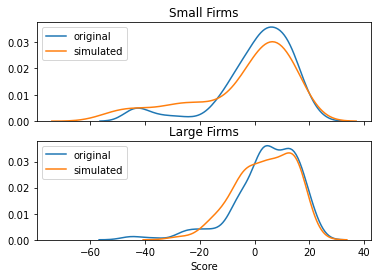

In [27]:
# plot scores of original and simulated data
fig, ax = plt.subplots(2, 1, sharex=True)
for size, number in [("Small Firms", 0), ("Large Firms", 1)]:
    ax[number].set_title(size)
    ax[1].set_xlabel("Score")
    sns.kdeplot(original_data.loc[original_data["largem"]==number, "s"], ax=ax[number], label="original")
    sns.kdeplot(simulated_data.loc[simulated_data["large"]==number, "score"], ax=ax[number], label="simulated")

In the original paper, the authors run the polynomial regression with $P \in \{0, 1, 2, 3\}$ and choose the optimal model according to the AIC which is readily available when running a linear regression. 

### References


Bronzini, R., & Iachini, E. (2014). Are incentives for R&D effective? Evidence from a regression discontinuity approach. *American Economic Journal: Economic Policy, 6*(4), 100-134.

Button, P. (2016). Model uncertainty and model averaging in regression discontinuity designs. *Journal of Econometric Methods, 5*(1), 103-116.

Fletcher, D. (2019). Model Averaging. Springer.

Hansen, B. E., & Racine, J. S. (2012). Jackknife model averaging. *Journal of Econometrics, 167*(1), 38-46.

Imbens, G. W., & Lemieux, T. (2008). Regression discontinuity designs: A guide to practice. *Journal of econometrics, 142*(2), 615-635.

Lee, D. S., & Lemieux, T. (2010). Regression discontinuity designs in economics. *Journal of economic literature, 48*(2), 281-355.

Li, K. C. (1987). Asymptotic optimality for Cp, CL, cross-validation and generalized cross-validation: discrete index set. *The Annals of Statistics, 958-975*.

Moral‐Benito, E. (2015). Model averaging in economics: An overview. *Journal of Economic Surveys, 29*(1), 46-75.

Steel, M. F. (forthcoming). Model Averaging and Its Use in Economics. *Journal of Economic Literature*.

Stone, M. (1974). Cross‐validatory choice and assessment of statistical predictions. *Journal of the Royal Statistical Society: Series B (Methodological), 36*(2), 111-133.

Wolpert, D. H. (1992). Stacked generalization. *Neural networks, 5*(2), 241-259.